In [51]:
import os
import numpy as np
import pandas as pd
from struct import unpack

PATH = 'data/sample/'
FILES = [file for file in os.listdir(PATH) if file != '.gitkeep' and file != 'stage1_labels.csv' and file != "body_zones.png"]

In [52]:
def read_header(file, path): # good default value path=PATH
    """Read image header (first 512 bytes)"""
    h = dict()
    with open(path+file, 'rb') as f:
        header = f.read(512)
    h['filename'], h['parent_filename'], h['comments1'], h['comments2'] = unpack('20s20s80s80s', header[:200])
    h['energy_type'], h['config_type'], h['file_type'], h['trans_type'], h['scan_type'], h['data_type'] = unpack('6h', header[200:212])
    h['date_modified'], h['frequency'], h['mat_velocity'], h['num_pts'] = unpack('16s2fi', header[212:240])
    h['num_polarization_channels'], h['spare00'] = unpack('2h', header[240:244])
    h['adc_min_voltage'], h['adc_max_voltage'], h['band_width'] = unpack('3f', header[244:256])
    h['spare01'], h['spare02'], h['spare03'], h['spare04'], h['spare05'] = unpack('5h', header[256:266])
    h['polar_t1'], h['polar_t2'], h['polar_t3'], h['polar_t4'] = unpack('4h', header[266:274])
    h['record_header_size'], h['word_type'], h['word_precision'] = unpack('3h', header[274:280])
    h['min_data_value'], h['max_data_value'], h['avg_data_value'], h['data_scale_factor'] = unpack('4f', header[280:296])
    h['data_units'] = unpack('h', header[296:298])
    h['surf_removal'], h['edge_weighting'], h['x_units'], h['y_units'], h['z_units'], h['t_units'] = unpack('6H', header[298:310])
    h['spare06'] = unpack('h', header[310:312])
    h['x_return_speed'], h['y_return_speed'], h['z_return_speed'] = unpack('3f', header[312:324])
    h['scan_orientation'], h['scan_direction'], h['data_storage_order'], h['scanner_type'] = unpack('4h', header[324:332])
    h['x_inc'], h['y_inc'], h['z_inc'], h['t_inc'] = unpack('4f', header[332:348])
    h['num_x_pts'], h['num_y_pts'], h['num_z_pts'], h['num_t_pts'] = unpack('4i', header[348:364])
    h['x_speed'], h['y_speed'], h['z_speed'] = unpack('3f', header[364:376])
    h['x_acc'], h['y_acc'], h['z_acc'] = unpack('3f', header[376:388])
    h['x_motor_res'], h['y_motor_res'], h['z_motor_res'] = unpack('3f', header[388:400])
    h['x_encoder_res'], h['y_encoder_res'], h['z_encoder_res'] = unpack('3f', header[400:412])
    h['date_processed'], h['time_processed'] = unpack('8s8s', header[412:428])
    h['depth_recon'], h['x_max_travel'], h['y_max_travel'], h['elevation_offset_angle'] = unpack('4f', header[428:444])
    h['roll_offset_angle'], h['z_max_travel'], h['azimuth_offset_angle'] = unpack('3f', header[444:456])
    h['adc_type'], h['spare06'], h['scanner_radius'] = unpack('2hf', header[456:464])
    h['x_offset'], h['y_offset'], h['z_offset'], h['t_delay'] = unpack('4f', header[464:480])
    h['range_gate_start'], h['range_gate_end'], h['ahis_software_version'] = unpack('3f', header[480:492])
    h['spare07'], h['spare08'], h['spare09'], h['spare10'], h['spare11'], h['spare12'], \
    h['spare13'], h['spare14'], h['spare15'], h['spare16'] = unpack('10h', header[492:])
    return h

In [32]:
%timeit [read_header(file, PATH) for file in FILES]
#%timeit pd.DataFrame([read_header_orig(file) for file in FILES])
#%timeit pd.DataFrame([read_header(file) for file in FILES])

436 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
#df = pd.DataFrame([read_header_orig(file) for file in FILES])
#df.head()

In [ ]:
#df = pd.DataFrame([read_header(file) for file in FILES])
#df.head()

In [53]:
def read_data(file, path): # good default value path=PATH
    """Read any of the 4 types of image files, returns a numpy array of the image contents"""
    extension = file.split('.')[-1]
    with open(path+file, 'rb') as f:
        header = f.read(512)
        word_type = unpack('h', header[276:278])
        scale_factor = unpack('f', header[292:296])
        nx, ny, nz, nt = unpack('4i', header[348:364])
        if extension == 'ahi':
            data = np.fromfile(f, dtype=np.float32, count=2*nx*ny*nt)
            data = data.reshape(2, ny, nx, nt, order='F')
            return data[0,:,:,:], data[1,:,:,:]
        else:
            if word_type == 7: #float32
                data = np.fromfile(f, dtype=np.float32, count=nx*ny*nt)
            else:
                data = np.fromfile(f, dtype=np.uint16, count=nx*ny*nt)
            data = data * scale_factor
            if extension == 'a3d':
                return data.reshape(nx, nt, ny, order='F')
            return data.reshape(nx, ny, nt, order='F')

In [54]:
# [print(file) for file in FILES]
for file in FILES:
    print(file)

0043db5e8c819bffc15261b1f1ac5e42.a3daps
._00360f79fd6e02781457eda48f85da90.aps
._0043db5e8c819bffc15261b1f1ac5e42.ahi
00360f79fd6e02781457eda48f85da90.aps
._0043db5e8c819bffc15261b1f1ac5e42.a3d
00360f79fd6e02781457eda48f85da90.ahi
00360f79fd6e02781457eda48f85da90.a3daps
._00360f79fd6e02781457eda48f85da90.a3daps
._00360f79fd6e02781457eda48f85da90.ahi
._00360f79fd6e02781457eda48f85da90.a3d
._0043db5e8c819bffc15261b1f1ac5e42.aps
._0043db5e8c819bffc15261b1f1ac5e42.a3daps
0043db5e8c819bffc15261b1f1ac5e42.ahi
0043db5e8c819bffc15261b1f1ac5e42.a3d
0043db5e8c819bffc15261b1f1ac5e42.aps
00360f79fd6e02781457eda48f85da90.a3d


Populating the interactive namespace from numpy and matplotlib
0043db5e8c819bffc15261b1f1ac5e42.a3daps
(512, 660, 64)


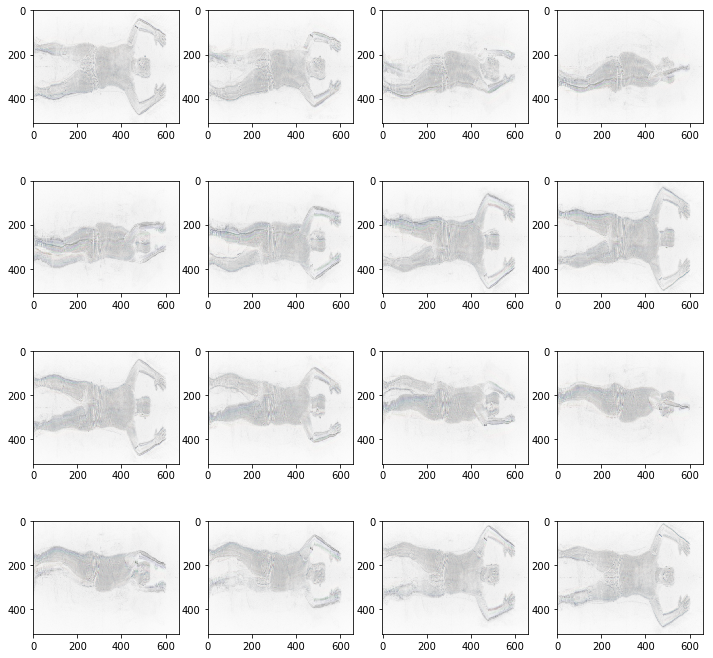

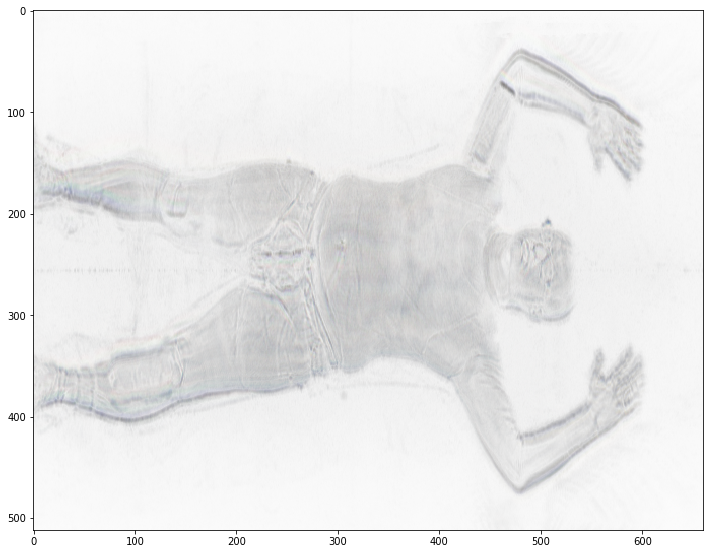

In [55]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(FILES[0])
fig = plt.figure(figsize=(12, 12))

img = read_data(FILES[0], PATH)
print(img.shape)
for i in range(16):
    a=fig.add_subplot(4, 4, i + 1)
    # imgplot = plt.imshow(img[:, :, 4:8])
    imgplot = plt.imshow(img[:, :, 4 * i : 4 * i + 4])
plt.show()

fig1 = plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, :4])
plt.show()

In [35]:
# imports
from __future__ import print_function
from __future__ import division
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import scipy.stats as stats

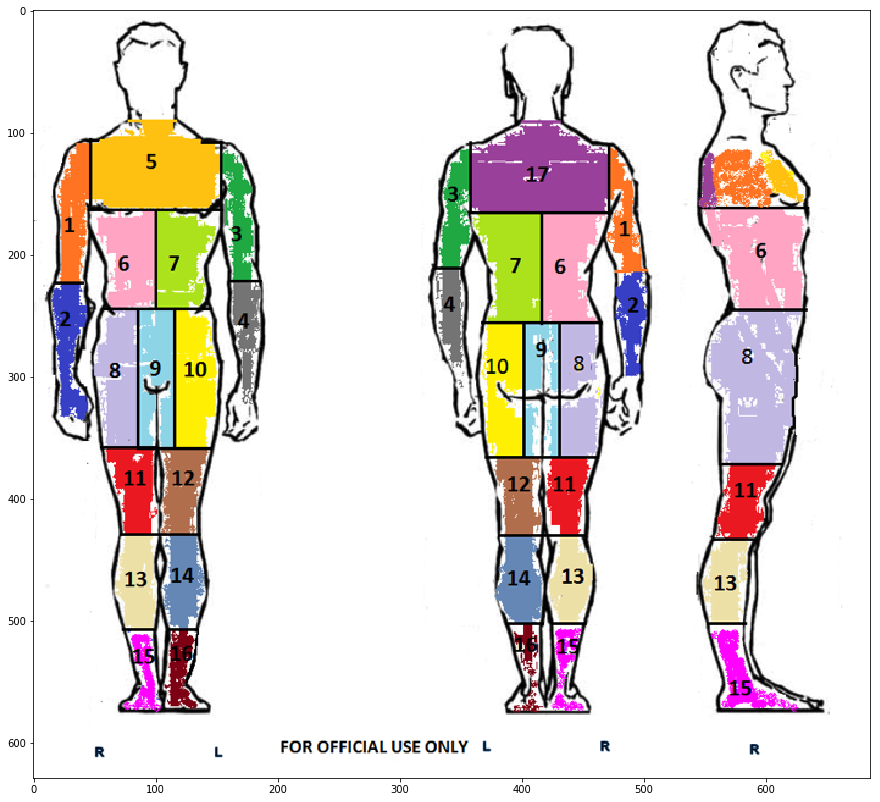

In [36]:
# constants
COLORMAP = 'pink'
APS_FILE_NAME = 'data/sample/00360f79fd6e02781457eda48f85da90.aps'
BODY_ZONES = 'data/sample/body_zones.png'
THREAT_LABELS = 'data/sample/stage1_labels.csv'


# show the threat zones
body_zones_img = plt.imread(BODY_ZONES)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(body_zones_img)

### Segmenting and Cropping the Scans

In [37]:
# Divide the available space on an image into 16 sectors. In the [0] image these
# zones correspond to the TSA threat zones.  But on rotated images, the slice
# list uses the sector that best shows the threat zone
sector01_pts = np.array([[0,160],[200,160],[200,230],[0,230]], np.int32)
sector02_pts = np.array([[0,0],[200,0],[200,160],[0,160]], np.int32)
sector03_pts = np.array([[330,160],[512,160],[512,240],[330,240]], np.int32)
sector04_pts = np.array([[350,0],[512,0],[512,160],[350,160]], np.int32)

# sector 5 is used for both threat zone 5 and 17
sector05_pts = np.array([[0,220],[512,220],[512,300],[0,300]], np.int32) 

sector06_pts = np.array([[0,300],[256,300],[256,360],[0,360]], np.int32)
sector07_pts = np.array([[256,300],[512,300],[512,360],[256,360]], np.int32)
sector08_pts = np.array([[0,370],[225,370],[225,450],[0,450]], np.int32)
sector09_pts = np.array([[225,370],[275,370],[275,450],[225,450]], np.int32)
sector10_pts = np.array([[275,370],[512,370],[512,450],[275,450]], np.int32)
sector11_pts = np.array([[0,450],[256,450],[256,525],[0,525]], np.int32)
sector12_pts = np.array([[256,450],[512,450],[512,525],[256,525]], np.int32)
sector13_pts = np.array([[0,525],[256,525],[256,600],[0,600]], np.int32)
sector14_pts = np.array([[256,525],[512,525],[512,600],[256,600]], np.int32)
sector15_pts = np.array([[0,600],[256,600],[256,660],[0,660]], np.int32)
sector16_pts = np.array([[256,600],[512,600],[512,660],[256,660]], np.int32)

# crop dimensions, upper left x, y, width, height
sector_crop_list = [[ 50,  50, 250, 250], # sector 1
                    [  0,   0, 250, 250], # sector 2
                    [ 50, 250, 250, 250], # sector 3
                    [250,   0, 250, 250], # sector 4
                    [150, 150, 250, 250], # sector 5/17
                    [200, 100, 250, 250], # sector 6
                    [200, 150, 250, 250], # sector 7
                    [250,  50, 250, 250], # sector 8
                    [250, 150, 250, 250], # sector 9
                    [300, 200, 250, 250], # sector 10
                    [400, 100, 250, 250], # sector 11
                    [350, 200, 250, 250], # sector 12
                    [410,   0, 250, 250], # sector 13
                    [410, 200, 250, 250], # sector 14
                    [410,   0, 250, 250], # sector 15
                    [410, 200, 250, 250], # sector 16
                   ]

### Threat Zone Slice Lists and Crop Lists

In [38]:
# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_slice_list = [ [ # threat zone 1
                      sector01_pts, sector01_pts, sector01_pts, None, 
                      None, None, sector03_pts, sector03_pts, 
                      sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts, sector01_pts ], 
    
                    [ # threat zone 2
                      sector02_pts, sector02_pts, sector02_pts, None, 
                      None, None, sector04_pts, sector04_pts, 
                      sector04_pts, sector04_pts, sector04_pts, None, 
                      None, sector02_pts, sector02_pts, sector02_pts ],
    
                    [ # threat zone 3
                      sector03_pts, sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts,
                      sector01_pts, sector01_pts, sector01_pts, sector01_pts, 
                      None, None, sector03_pts, sector03_pts ],
    
                    [ # threat zone 4
                      sector04_pts, sector04_pts, sector04_pts, sector04_pts, 
                      None, None, sector02_pts, sector02_pts, 
                      sector02_pts, sector02_pts, sector02_pts, sector02_pts, 
                      None, None, sector04_pts, sector04_pts ],
    
                    [ # threat zone 5
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts,
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 6
                      sector06_pts, None, None, None, 
                      None, None, None, None, 
                      sector07_pts, sector07_pts, sector06_pts, sector06_pts, 
                      sector06_pts, sector06_pts, sector06_pts, sector06_pts ],
    
                    [ # threat zone 7
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 8
                      sector08_pts, sector08_pts, None, None, 
                      None, None, None, sector10_pts, 
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector08_pts, sector08_pts, sector08_pts, sector08_pts ],
    
                    [ # threat zone 9
                      sector09_pts, sector09_pts, sector08_pts, sector08_pts, 
                      sector08_pts, None, None, None,
                      sector09_pts, sector09_pts, None, None, 
                      None, None, sector10_pts, sector09_pts ],
    
                    [ # threat zone 10
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector10_pts, sector08_pts, sector10_pts, None, 
                      None, None, None, None, 
                      None, None, None, sector10_pts ],
    
                    [ # threat zone 11
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts, 
                      None, None, sector12_pts, sector12_pts,
                      sector12_pts, sector12_pts, sector12_pts, None, 
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts ],
    
                    [ # threat zone 12
                      sector12_pts, sector12_pts, sector12_pts, sector12_pts, 
                      sector12_pts, sector11_pts, sector11_pts, sector11_pts, 
                      sector11_pts, sector11_pts, sector11_pts, None, 
                      None, sector12_pts, sector12_pts, sector12_pts ],
    
                    [ # threat zone 13
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts, 
                      None, None, sector14_pts, sector14_pts,
                      sector14_pts, sector14_pts, sector14_pts, None, 
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts ],
    
                    [ # sector 14
                      sector14_pts, sector14_pts, sector14_pts, sector14_pts, 
                      sector14_pts, None, sector13_pts, sector13_pts, 
                      sector13_pts, sector13_pts, sector13_pts, None, 
                      None, None, None, None ],
    
                    [ # threat zone 15
                      sector15_pts, sector15_pts, sector15_pts, sector15_pts, 
                      None, None, sector16_pts, sector16_pts,
                      sector16_pts, sector16_pts, None, sector15_pts, 
                      sector15_pts, None, sector15_pts, sector15_pts ],
    
                    [ # threat zone 16
                      sector16_pts, sector16_pts, sector16_pts, sector16_pts, 
                      sector16_pts, sector16_pts, sector15_pts, sector15_pts, 
                      sector15_pts, sector15_pts, sector15_pts, None, 
                      None, None, sector16_pts, sector16_pts ],
    
                    [ # threat zone 17
                      None, None, None, None, 
                      None, None, None, None,
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts ] ]

# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_crop_list =  [ [ # threat zone 1
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], None, 
                      None, None, sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], None, 
                      None, sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0] ],
    
                    [ # threat zone 2
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], None, 
                      None, None, sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      None, None, sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1] ],
    
                    [ # threat zone 3
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], None, None, sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], None, None, 
                      sector_crop_list[2], sector_crop_list[2] ],
               
                    [ # threat zone 4
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], None, None, sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], None, None, 
                      sector_crop_list[3], sector_crop_list[3] ],
                    
                    [ # threat zone 5
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4],
                      None, None, None, None, None, None, None, None ],
                    
                    [ # threat zone 6
                      sector_crop_list[5], None, None, None, None, None, None, None, 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5] ],
    
                    [ # threat zone 7
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], 
                      None, None, None, None, None, None, None, None ],
    
                    [ # threat zone 8
                      sector_crop_list[7], sector_crop_list[7], None, None, None, 
                      None, None, sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[7], sector_crop_list[7], sector_crop_list[7], 
                      sector_crop_list[7] ],
    
                    [ # threat zone 9
                      sector_crop_list[8], sector_crop_list[8], sector_crop_list[7], 
                      sector_crop_list[7], sector_crop_list[7], None, None, None,
                      sector_crop_list[8], sector_crop_list[8], None, None, None, 
                      None, sector_crop_list[9], sector_crop_list[8] ],
    
                    [ # threat zone 10
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[7], 
                      sector_crop_list[9], None, None, None, None, None, None, None, 
                      None, sector_crop_list[9] ],
    
                    [ # threat zone 11
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10], 
                      sector_crop_list[10], None, None, sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], None, sector_crop_list[10], 
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10] ],
    
                    [ # threat zone 12
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], None, None, 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11] ],
    
                    [ # threat zone 13
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12], 
                      sector_crop_list[12], None, None, sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], None, sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12] ],
    
                    [ # sector 14
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], None, 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], None, None, None, 
                      None, None ],
    
                    [ # threat zone 15
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], None, None, sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      None, sector_crop_list[14], sector_crop_list[14], None, 
                      sector_crop_list[14], sector_crop_list[14] ],
    
                    [ # threat zone 16
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], sector_crop_list[14], None, None, None, 
                      sector_crop_list[15], sector_crop_list[15] ],
    
                    [ # threat zone 17
                      None, None, None, None, None, None, None, None,
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4] ] ]

### Basic Descriptive Probabilities for Each Threat Zone

In [39]:
def get_hit_rate_stats(infile):
    # pull the labels for a given patient
    df = pd.read_csv(infile)

    # Separate the zone and patient id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]

    # make a df of the sums and counts by zone and calculate hit rate per zone, then sort high to low
    df_summary = df.groupby('Zone')['Probability'].agg(['sum','count'])
    df_summary['Zone'] = df_summary.index
    df_summary['pct'] = df_summary['sum'] / df_summary['count']
    df_summary.sort_values('pct', axis=0, ascending= False, inplace=True)
    
    return df_summary

# unit test -----------------------
df = get_hit_rate_stats(THREAT_LABELS)
df.head()

,sum,count,Zone,pct
Zone,,,,
Zone1,133,1147,Zone1,0.115955
Zone2,126,1147,Zone2,0.109852
Zone8,124,1147,Zone8,0.108108
Zone14,122,1147,Zone14,0.106364
Zone15,118,1147,Zone15,0.102877


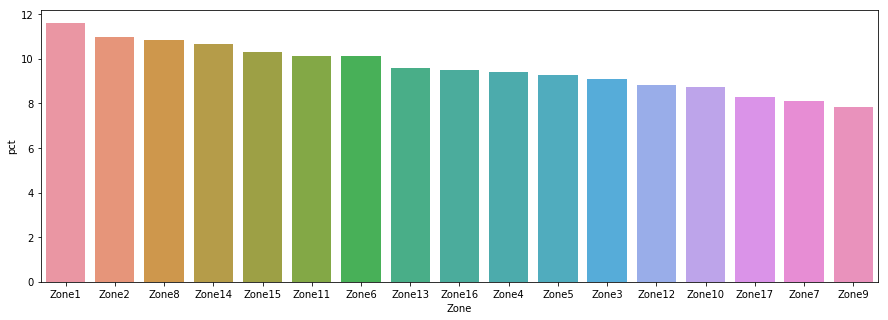

In [40]:
def chart_hit_rate_stats(df_summary):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.barplot(ax=ax, x=df_summary['Zone'], y=df_summary['pct']*100)

# unit test ------------------
chart_hit_rate_stats(df)

Done!


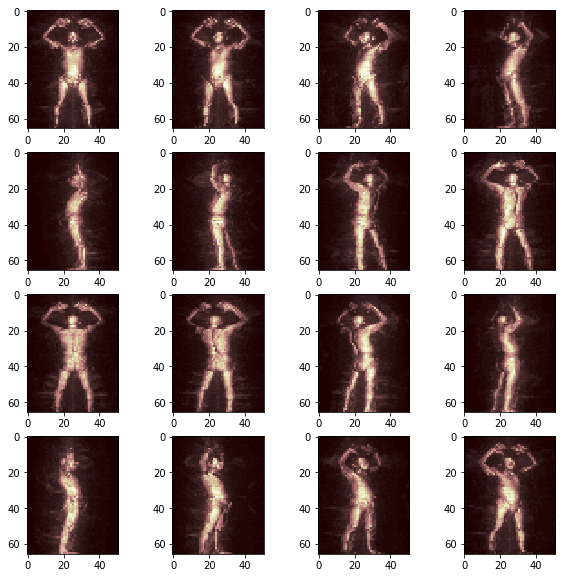

In [41]:
def plot_image_set(infile):

    # read in the aps file, it comes in as shape(512, 620, 16)
    img = read_data(infile, "")
    
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()
        
    # show the graphs
    fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    
    i = 0
    for row in range(4):
        for col in range(4):
            resized_img = cv2.resize(img[i], (0,0), fx=0.1, fy=0.1)
            axarr[row, col].imshow(np.flipud(resized_img), cmap=COLORMAP)
            i += 1
    
    print('Done!')

# unit test ----------------------------------
plot_image_set(APS_FILE_NAME)

### Digging into the Images

In [42]:
def get_single_image(infile, nth_image):

    # read in the aps file, it comes in as shape(512, 620, 16)
    img = read_data(infile, "")
    
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()
    
    return np.flipud(img[nth_image])

### Masking the Region of Interest

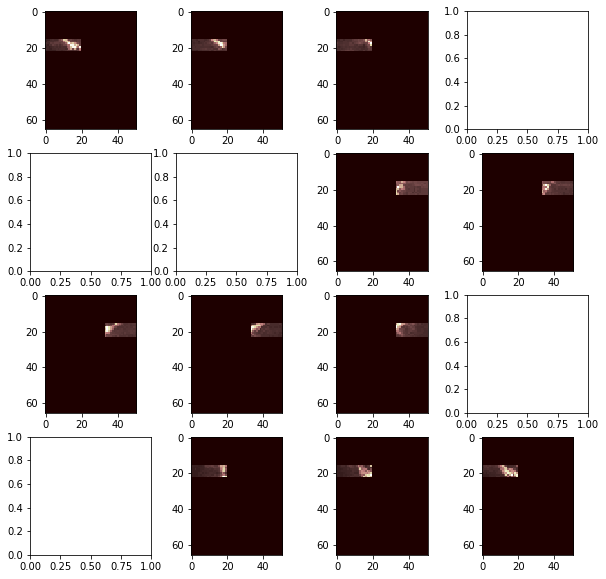

In [45]:
from scipy import stats

def convert_to_grayscale(img):
    # scale pixel values to grayscale
    base_range = np.amax(img) - np.amin(img)
    rescaled_range = 255 - 0
    img_rescaled = (((img - np.amin(img)) * rescaled_range) / base_range)

    return np.uint8(img_rescaled)

def spread_spectrum(img):
    # img = stats.threshold(img, threshmin=12, newval=0)
    
    # see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img= clahe.apply(img)
    
    return img


def roi(img, vertices):
    
    # blank mask
    mask = np.zeros_like(img)

    # fill the mask
    cv2.fillPoly(mask, [vertices], 255)

    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    

    return masked
  
# unit test -----------------------------------------------------------------
fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    
i = 0
for row in range(4):
    for col in range(4):
        an_img = get_single_image(APS_FILE_NAME, i)
        img_rescaled = convert_to_grayscale(an_img)
        img_high_contrast = spread_spectrum(img_rescaled)
        if zone_slice_list[0][i] is not None:
            masked_img = roi(img_high_contrast, zone_slice_list[0][i])
            resized_img = cv2.resize(masked_img, (0,0), fx=0.1, fy=0.1)
            axarr[row, col].imshow(resized_img, cmap=COLORMAP)
        i += 1